In [12]:
import numpy as np
import pyspiel
import matplotlib.pyplot as plt
from collections import defaultdict
from open_spiel.python import policy
from open_spiel.python.algorithms import exploitability

0回目 expl: 2.373611111111111
10回目 expl: 2.3147763586045627
20回目 expl: 2.2734897956018942
30回目 expl: 2.274709769011472
40回目 expl: 2.2676799865625314
50回目 expl: 2.2875188666001876
60回目 expl: 2.2895005702500835
70回目 expl: 2.305452267490433
80回目 expl: 2.2892919893367276
90回目 expl: 2.2718866719462514


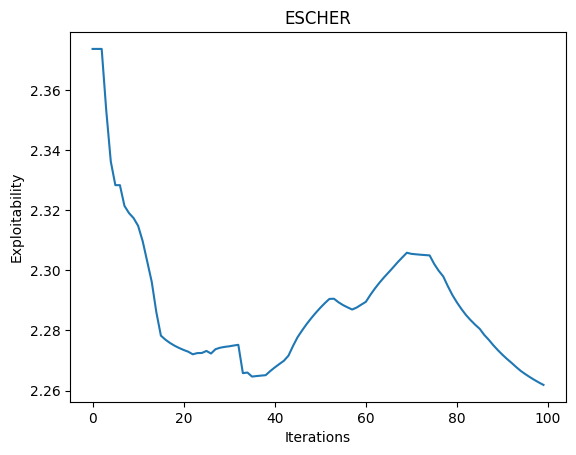

In [46]:
class TabularInfoState:
    def __init__(self, n):
        self.regret = np.zeros(n)
        self.strategy = np.zeros(n)

class UniformSampler:
    def __call__(self, infostate, n):
        return np.full(n, 1.0 / n)

class AveragePolicy(policy.Policy):
    def __init__(self, game, player_ids, cum_strategy):
        super().__init__(game, player_ids)
        self.game = game
        self.cum_strategy = cum_strategy

    def action_probabilities(self, state, player_id=None):
        if player_id is None:
            player_id = state.current_player()
        legal_actions_mask = np.array(state.legal_actions_mask())
        tmp_policy = self.cum_strategy[state.information_state_string()]
        if tmp_policy.sum() > 0:
            tmp_policy = tmp_policy / tmp_policy.sum()
        else:
            tmp_policy = legal_actions_mask / legal_actions_mask.sum()
        return {i: tmp_policy[i] for i in range(self.game.num_distinct_actions())}


class TabularESCHERSolver:
    def __init__(self, game):
        self.game = game
        self.sample_policy = UniformSampler()
        self.I = {}
        self.value = {}
        self.rng = np.random.default_rng()
        self.cum_strategies = defaultdict(lambda: np.zeros(game.num_distinct_actions()))
        self.exploitability_history = []


    def regret_match_strategy(self, infostate, state):
        legal_actions = state.legal_actions()
        legal_actions_mask = np.array(state.legal_actions_mask())
        pos_regret = np.maximum(infostate.regret, 0)
        sum_regret = np.sum(pos_regret)
        if sum_regret > 0:
            return pos_regret / sum_regret
        else:
            #print(f'legal_actions: {legal_actions}, policies: {legal_actions_mask / legal_actions_mask.sum()}')
            return legal_actions_mask / legal_actions_mask.sum()

    def infostate(self, h, n):
        infokey = h.information_state_string()
        if infokey not in self.I:
            self.I[infokey] = TabularInfoState(n)
        return self.I[infokey]

    def train(self, T, show_progress=True):
        for t in range(T):
            # 全ての状態価値を事前に計算
            self.fill_all_values(self.game.new_initial_state())
            for p in [0, 1]:
                self.traverse(self.game.new_initial_state(), p)
            # Update cumulative strategies
            for k, v in self.I.items():
                if len(self.cum_strategies[k]) != len(v.strategy):
                    self.cum_strategies[k] = v.strategy
                else:
                    self.cum_strategies[k] += v.strategy
            # Calculate exploitability and store it
            if (t + 1) % 1 == 0:
                ave_policy = AveragePolicy(self.game, list(range(self.game.num_players())), self.cum_strategies)
                expl = exploitability.exploitability(self.game, ave_policy)
                self.exploitability_history.append(expl)
                if t % 10 == 0 and show_progress:
                    print(f'{t}回目 expl: {expl}')

    def traverse(self, state, p):
        if state.is_terminal():
            return state.returns()[p]
        elif state.is_chance_node():
            outcomes_with_probs = state.chance_outcomes()
            action_list, prob_list = zip(*outcomes_with_probs)
            action = self.rng.choice(action_list, p=prob_list)
            state.apply_action(action)
            return self.traverse(state, p)

        infokey = state.information_state_string()
        legal_actions = state.legal_actions()
        legal_actions_mask = state.legal_actions_mask()
        I = self.infostate(state, max(legal_actions) + 1)

        if state.current_player() == p:
            pi_sample = self.sample_policy(I, len(legal_actions))
            sigma = self.regret_match_strategy(I, state)
            action = self.rng.choice(legal_actions, p=pi_sample)
            v = 0.0
            #if len(legal_actions) != len(sigma):
                #print(f'! legal_actions: {legal_actions}, sigma: {sigma}')
            r_hat = np.zeros(len(sigma))
            for  a in legal_actions:
                state_copy = state.child(a)
                q = self.value[tuple(state_copy.history())]
                if p != 0:
                    q *= -1
                r_hat[a] = q
                v += sigma[a] * q
            #v = self.value[tuple(state.history())]
            for a in legal_actions:
                r_hat[a] -= v
            if len(I.regret) != len(r_hat):
                I.regret = r_hat
                I.strategy = sigma
            else:
                I.regret += r_hat
                I.strategy += sigma
            state.apply_action(action)
            return self.traverse(state, p)
        else:
            pi_ni = self.regret_match_strategy(I, state)
            action = self.rng.choice(np.arange(len(pi_ni)), p=pi_ni)
            state.apply_action(action)
            return self.traverse(state, p)

    def fill_all_values(self, state):
        if state.is_terminal():
            u = state.returns()[0]
            self.value[tuple(state.history())] = u
            return u
        elif state.is_chance_node():
            outcomes_with_probs = state.chance_outcomes()
            v = 0.0
            for action, prob in outcomes_with_probs:
                state_copy = state.child(action)
                v += prob * self.fill_all_values(state_copy)
            self.value[tuple(state.history())] = v
            return v
        else:
            infokey = state.information_state_string()
            sigma = self.regret_match_strategy(self.infostate(state, len(state.legal_actions())), state)
            v = 0.0
            for a in state.legal_actions():
                state_copy = state.child(a)
                v += sigma[a] * self.fill_all_values(state_copy)
            self.value[tuple(state.history())] = v
            return v


game = pyspiel.load_game("leduc_poker") # kuhn_pokerはプレイヤーが0,1
solver = TabularESCHERSolver(game)
solver.train(100)

plt.plot(solver.exploitability_history)
plt.xlabel('Iterations')
plt.ylabel('Exploitability')
plt.title('ESCHER')
plt.show()

0回目 expl: 0.45833333333333326
10回目 expl: 0.3331845238095238
20回目 expl: 0.24814427400711572
30回目 expl: 0.2215200326739748
40回目 expl: 0.20371707782488366
50回目 expl: 0.18613839665912976
60回目 expl: 0.16977081587885895
70回目 expl: 0.15460332349461225
80回目 expl: 0.13927323785179307
90回目 expl: 0.122585167779654
100回目 expl: 0.11210728312335927
110回目 expl: 0.1060760851459811
120回目 expl: 0.1028213611600102
130回目 expl: 0.10107953543486992
140回目 expl: 0.10017213511460007
150回目 expl: 0.09891034238379626
160回目 expl: 0.0969978734064158
170回目 expl: 0.09766590955943827
180回目 expl: 0.09878666559553861
190回目 expl: 0.09955950487602361
200回目 expl: 0.10024287910789487
210回目 expl: 0.10068391417247363
220回目 expl: 0.10082177667034681
230回目 expl: 0.10058523235559863
240回目 expl: 0.0999146367645117
250回目 expl: 0.09911377600115637
260回目 expl: 0.09807756522305558
270回目 expl: 0.09689857433893634
280回目 expl: 0.09558954535695555
290回目 expl: 0.0943770679384072
300回目 expl: 0.0933762586899495
310回目 expl: 0.092533189111555

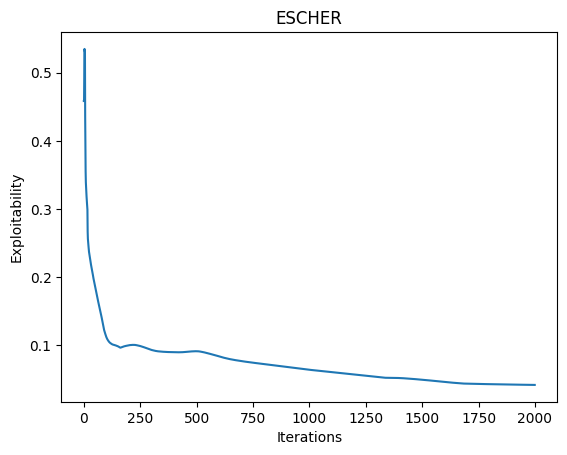

In [9]:
game = pyspiel.load_game("kuhn_poker") # kuhn_pokerはプレイヤーが0,1
solver = TabularESCHERSolver(game)
solver.train(2000)

plt.plot(solver.exploitability_history)
plt.xlabel('Iterations')
plt.ylabel('Exploitability')
plt.title('ESCHER')
plt.show()

0回目 expl: 2.373611111111111
10回目 expl: 2.338397144633557
20回目 expl: 2.325539216476547
30回目 expl: 2.3255248666661625
40回目 expl: 2.3412533659436723
50回目 expl: 2.3561412302543063
60回目 expl: 2.3643365767361666
70回目 expl: 2.353702066048249
80回目 expl: 2.328118699141806
90回目 expl: 2.297574046469993
100回目 expl: 2.28624190217245
110回目 expl: 2.2793480752086928
120回目 expl: 2.274460069870131
130回目 expl: 2.2712907942171823
140回目 expl: 2.2678974662760183
150回目 expl: 2.266796030844368
160回目 expl: 2.264391711618152
170回目 expl: 2.2620295346323362
180回目 expl: 2.2592016366883803
190回目 expl: 2.2582516636006873
200回目 expl: 2.256664355449737
210回目 expl: 2.254783686560815
220回目 expl: 2.2527980910379686
230回目 expl: 2.251736880564585
240回目 expl: 2.251129467257561
250回目 expl: 2.2504292295114054
260回目 expl: 2.2498103843646415
270回目 expl: 2.254732781903326
280回目 expl: 2.253845428841184
290回目 expl: 2.2518179790081128
300回目 expl: 2.248939492072095
310回目 expl: 2.246902143285328
320回目 expl: 2.245520529637675
330回目 ex

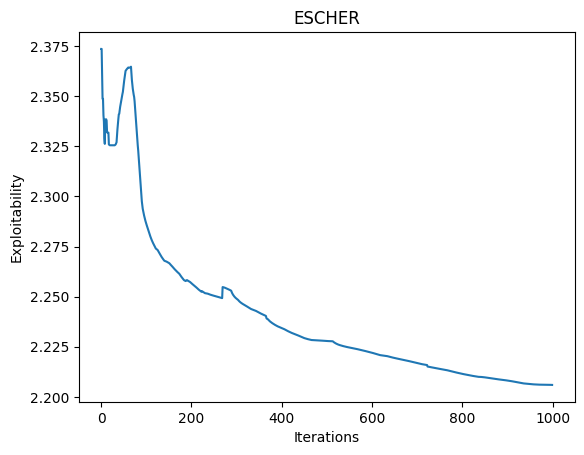

In [10]:
game = pyspiel.load_game("leduc_poker") # kuhn_pokerはプレイヤーが0,1
solver = TabularESCHERSolver(game)
solver.train(1000)

plt.plot(solver.exploitability_history)
plt.xlabel('Iterations')
plt.ylabel('Exploitability')
plt.title('ESCHER')
plt.show()